### Install required libraries

In [1]:
!pip install -q gdown patool numpy pandas matplotlib torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import gdown
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from timm.loss import LabelSmoothingCrossEntropy # Better than nn.CrossEntropyLoss

%matplotlib inline

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Download training and validation data from Google Drive

In [3]:
file_id = "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
file_name = "Project_data.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name)

Downloading...
From (original): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
From (redirected): https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t&uuid=7167b376-6cbf-4f8f-aaef-384b0435d95b
To: /content/Project_data.zip
100%|██████████| 1.71G/1.71G [00:14<00:00, 114MB/s]


'Project_data.zip'

In [4]:
# Remove extracted files if already exist
!rm -rf 'Project_data'
# Unzip file
!unzip -qq Project_data.zip

In [5]:
data_root_dir = "/content/Project_data"
train_images_dir = os.path.join(data_root_dir, 'train')
val_images_dir = os.path.join(data_root_dir, 'val')
train_csv_file = os.path.join(data_root_dir, 'train.csv')
val_csv_file = os.path.join(data_root_dir, 'val.csv')

In [6]:
train_data_df = pd.read_csv(train_csv_file)
df = pd.DataFrame(train_data_df.iloc[:, 0].str.split(';').tolist(), columns = ['folder', 'label','class'])
classes = df['class'].unique()

In [32]:
# Hyperparameters
torch.manual_seed(2809)
num_epochs = 5
batch_size = 8
image_size = 256
learning_rate = 0.001

In [33]:
class CustomVideoDataset(Dataset):

  def __init__(self, images_dir, data_file, transform):

    self.images_dir = images_dir
    self.transform = transform
    data_df = pd.read_csv(data_file)
    self.data = data_df.iloc[:, 0].str.split(';')

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    images = []
    images_path = os.path.join(self.images_dir, self.data[index][0])
    # print(f'Loading video images from folder {images_path}')
    for image_file in os.scandir(images_path):
      image = Image.open(os.path.join(images_path, image_file))
      if self.transform:
        image = self.transform(image)
      images.append(image)

    label = self.data[index][2]

    images = torch.stack(images)
    labels = torch.tensor(int(label), dtype=torch.long)

    return images, labels


In [34]:
transform = transforms.Compose([
  transforms.Resize((image_size, image_size)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = CustomVideoDataset(train_images_dir, train_csv_file, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

val_dataset = CustomVideoDataset(val_images_dir, val_csv_file, transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [35]:
def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    tensor.mul_(std).add_(mean)
    return tensor

Train images shape: torch.Size([8, 30, 3, 256, 256])


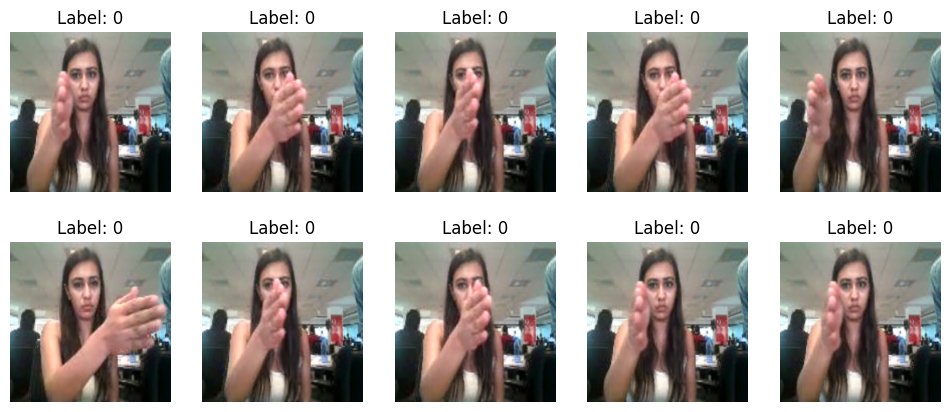

In [36]:
batch_of_video_image_frames, labels = next(iter(train_loader))
print(f'Train images shape: {batch_of_video_image_frames.shape}')

_, axs = plt.subplots(2, 5, figsize=(12, 5))

index = 0
for row in range(2):
  for col in range(5):
    input_tensor= inverse_normalize(tensor=batch_of_video_image_frames[0][index])
    img = input_tensor.squeeze(0)
    axs[row, col].imshow(transforms.ToPILImage()(img))
    axs[row, col].set_title('Label: ' + str(labels[0].item()))
    axs[row, col].axis('off')
    index += 1

In [22]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(CNNLSTM, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x_3d):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t])
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(x.unsqueeze(0), hidden)

        # Get the last hidden state (hidden is a tuple with both hidden and cell state in it)
        x = self.fc1(hidden[0][-1])
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [45]:
model = CNNLSTM()
model.to(device)

criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
class SaveBestModel:

  def __init__(self, best_valid_loss=float('inf')):
    self.best_valid_loss = best_valid_loss

  def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
    if current_valid_loss < self.best_valid_loss:
      self.best_valid_loss = current_valid_loss
      print(f'Best validation loss: {self.best_valid_loss}')
      print(f'Saving best model for epoch: {epoch+1}')
      torch.save({
          'epoch': epoch+1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': criterion,
      }, 'best_model.pth')

In [40]:
def save_model(epochs, model, optimizer, criterion):
  print(f"Saving final model...")
  torch.save({
              'epoch': epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': criterion,
              }, 'final_model.pth')

In [41]:
# initialize SaveBestModel class
save_best_model = SaveBestModel()

In [47]:
def train(epoch, model, train_loader, optimizer, criterion):

  model.train()

  running_loss, running_corrects, running_total = 0.0, 0, 0

  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for i, (inputs, labels) in enumerate(tepoch):
      tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

      optimizer.zero_grad()

      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      loss = criterion(outputs, labels)

      predictions = torch.argmax(outputs, dim=1)
      corrects = (predictions == labels).sum().item()
      accuracy = corrects / inputs.size(0)

      running_loss += loss.item() * inputs.size(0)
      running_total += labels.size(0)
      running_corrects += corrects

      loss.backward()
      optimizer.step()

      tepoch.set_postfix(train_loss=loss.item(), train_accuracy=100. * accuracy)

      # print(f'running_total: {running_total}; running_loss: {running_loss}; running_corrects: {running_corrects}')

  # Calculate the training loss and training accuracy
  train_loss = running_loss / running_total
  train_accuracy = 100 * running_corrects / running_total
  # print(f'Epoch {epoch} - Training loss: {train_loss:.4f} Training accuracy: {train_accuracy:.2f}')
  return train_loss, train_accuracy


In [48]:
def validate(epoch, model, val_loader, criterion):

  running_val_loss, running_val_corrects, running_val_total = 0.0, 0, 0

  # Validation
  with torch.no_grad():
    model.eval()
    with tqdm(val_loader, unit="batch", total=len(val_loader)) as tepoch:
      for i, (inputs, labels) in enumerate(tepoch):
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
        corrects = (predictions == labels).sum().item()
        accuracy = corrects / inputs.size(0)

        tepoch.set_postfix(validation_loss=loss.item(), validation_accuracy=100. * accuracy)

        running_val_loss += loss.item() * inputs.size(0)
        running_val_total += labels.size(0)
        running_val_corrects += corrects

  # Calculate the training loss and training accuracy
  val_loss = running_val_loss / running_val_total
  val_accuracy = 100 * running_val_corrects / running_val_total
  # print(f'Epoch {epoch} - Validation loss: {val_loss:.4f} Validation accuracy: {val_accuracy:.2f}')
  return val_loss, val_accuracy


In [49]:
metrics = {'train_loss' : [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(num_epochs):
  train_loss, train_accuracy = train(epoch, model, train_loader, optimizer, criterion)
  val_loss, val_accuracy = validate(epoch, model, val_loader, criterion)
  metrics['train_loss'].append(train_loss)
  metrics['train_accuracy'].append(train_accuracy)
  metrics['val_loss'].append(val_loss)
  metrics['val_accuracy'].append(val_accuracy)
  save_best_model(val_loss, epoch, model, optimizer, criterion)


save_model(num_epochs, model, optimizer, criterion)

Epoch 1/5: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch, validation_accuracy=66.7, validation_loss=1.07]


Best validation loss: 1.3831849001874827
Saving best model for epoch: 1


Epoch 2/5:  41%|████      | 34/83 [00:43<01:02,  1.28s/batch, train_accuracy=25, train_loss=1.94]


KeyboardInterrupt: 

In [25]:
def plot_metrics_charts(metrics):
    acc = metrics['train_accuracy']
    val_acc = metrics['val_accuracy']

    loss = metrics['train_loss']
    val_loss = metrics['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()

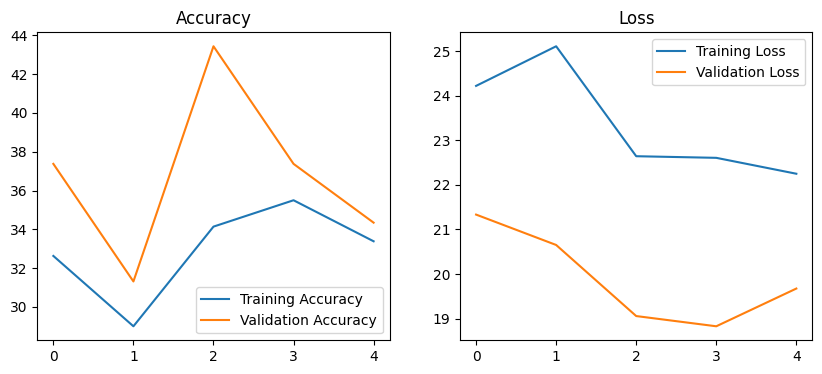

In [26]:
plot_metrics_charts(metrics)